# Install and imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/rl_final_proj/saved_models"
MODEL_FOLDER_PATH = "saved_models"

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XtcTWQDHh9g7KN-mjvynVWDwK7VWGGZR/rl_final_proj/saved_models


In [ ]:
!pip install -U gym --quiet
!pip install gym[box2d] --quiet

     |████████████████████████████████| 721 kB 8.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.8 MB 8.6 MB/s 
     |████████████████████████████████| 18.3 MB 147 kB/s 
     |████████████████████████████████| 374 kB 58.1 MB/s 
  ERROR: Failed building wheel for box2d-py
    Running setup.py install for box2d-py ... done
  DEPRECATION: box2d-py was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch import nn
from torch.functional import F
from torch.distributions import Categorical
from collections import deque
from math import prod
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
import random

# Model class

In [ ]:
class Memory(nn.Module):
  def __init__(self, new_data_size, history_size, hidden_size=32, num_layers=4):
    super().__init__()
    self.lstm = nn.LSTM(new_data_size, hidden_size, num_layers, batch_first=False)
    self.fc = nn.Linear(hidden_size, history_size)
    self.num_layers = num_layers
    self.hidden_size = hidden_size
  
  def forward(self, x):
    # Set initial hidden and cell states 
    h0 = torch.zeros(self.num_layers, self.hidden_size)
    c0 = torch.zeros(self.num_layers, self.hidden_size)
    
    # Forward propagate LSTM
    out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
    
    # Decode the hidden state of the last time step
    out = self.fc(out[-1, :])
    return out

In [ ]:
class Manager(nn.Module):
  def __init__(self, state_size, history_size, n_decisions):
    super().__init__()
    self.fc1 = nn.Linear(state_size + history_size, 8)
    self.fc2 = nn.Linear(8, n_decisions)
    self.softmax = nn.Softmax(0)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return self.softmax(x)

  def decide(self, x):

    probs = self.forward(x)
    m = Categorical(probs)
    route = m.sample()
    log_prob = m.log_prob(route)

    return route.item(), log_prob

In [ ]:
class Controller(nn.Module):
  def __init__(self, state_size, history_size, action_size):
    super().__init__()
    self.fc1 = nn.Linear(state_size + history_size, action_size)
    self.softmax = nn.Softmax(0)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    return self.softmax(x)
      
  def act(self, x):
    
    probs = self.forward(x)
    m = Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action.item(), log_prob

In [ ]:
class Imaginator(nn.Module):
  def __init__(self, state_size):
    super().__init__()
    self.state_imaginator = nn.Linear(state_size + 1, state_size)
    self.reward_imaginator = nn.Linear(state_size + 1, 1)

  def forward(self, state, action):
    input = torch.cat([state,action])
    s_prime = self.state_imaginator(input)
    reward = self.reward_imaginator(input)
    return F.relu(s_prime), F.relu(reward)

In [ ]:
def initialize_history(state_dim, action_dim):
  s = torch.zeros(state_dim).flatten()
  a = torch.zeros(action_dim)
  r = torch.zeros(1)
  u = torch.zeros(1)
  return torch.cat([s,a,r,u]) # 0 because is action in real world

# Train

In [ ]:
def train():

  # Hyperparameters
  n_training_episodes=5000
  max_episode_len=2000
  gamma=0.99
  n_step_budget = 4

  print_every=100
  save_every=200

  n_lstm_units = 4

  scores_deque = deque(maxlen=max_episode_len)

  plot_info = {"n_step_budget": n_step_budget,
               "n_episodes" : n_training_episodes,
               "Mean_reward_per_episode" : []
               }

  # Env
  env_id = "LunarLander-v2"
  env = gym.make(env_id)

  # Cart-pole env
  #env_id = "CartPole-v1"
  #env = gym.make(env_id)

  # Dimensions
  state_dim = env.observation_space.shape[0]
  action_dim = env.action_space.n
  history_size = state_dim + 1 + 1 + 1
  n_decisions = 3

  # Initialize models
  manager = Manager(state_dim, history_size, n_decisions)
  memory =  Memory(history_size, history_size, num_layers=n_lstm_units)
  controller = Controller(state_dim, history_size, action_dim)
  imaginator = Imaginator(state_dim)

  #if os.path.exists(f"{env_id}_checkpoint"):
  #  # Load models if you don't want to retrain from zero
  #  print("Loading pretrained models of the env:", env_id, "...")
  #  checkpoint = torch.load(f"{env_id}_checkpoint")
  #  manager.load_state_dict(checkpoint["manager"])
  #  memory.load_state_dict(checkpoint["memory"])
  #  controller.load_state_dict(checkpoint["controller"])
  #  imaginator.load_state_dict(checkpoint["imaginator"])
  #  print("Loading completed")

  # Optimizer
  lr_manager = 0.001
  lr_memory_and_controller = 0.003
  lr_imaginator = 0.001
  optimizer = torch.optim.Adam([
                      {'params': manager.parameters(), 'lr': lr_manager},
                      {'params': list(memory.parameters())+list(controller.parameters()), 'lr': lr_memory_and_controller},
                      {'params': imaginator.parameters(), 'lr': lr_imaginator}])

  # Train mode
  manager.train()
  memory.train()
  controller.train()
  imaginator.train()

  for i_episode in range(1, n_training_episodes+1):

        saved_log_probs_controller = [] 
        saved_log_probs_manager = []
        rewards = []
        im_rewards = []
        
        # Init episode
        state = env.reset()[0]
        last_states = [state,state]
        done = False
        history = initialize_history(state_dim, 1)

        counter_steps_in_episode = 0
        n_imagined = 0
        # Budget of n-step imagination
        n_imagined_steps_budget = n_step_budget
        cost_to_imagine = 0
        # Force the first action to be done in the real world
        u = 0

        while not done:
            if u==0 or n_imagined_steps_budget == 0:
              # Input = (last_real_state,history) ----> Step ----> Save (s',r') in 2 batches
              input = torch.cat([torch.tensor(last_states[0]).flatten(),history]).flatten()
              action, log_prob = controller.act(input)
              saved_log_probs_controller.append(log_prob)

              state, reward, done, _, _ = env.step(action)
              state_imagined, r_imagined = imaginator(torch.tensor(last_states[0]), torch.tensor([action]))

              # Real env batches
              if counter_steps_in_episode == 0:
                batch_states = torch.tensor(state).unsqueeze(0)
                batch_rewards = torch.tensor([reward]).unsqueeze(0)
              else:
                batch_states = torch.cat([torch.tensor(state)])
                batch_rewards = torch.cat([torch.tensor([reward])])
              
              # Imagined batches for the imaginator loss
              if counter_steps_in_episode == 0:
                batch_states_im = torch.tensor(state_imagined).unsqueeze(0)
                batch_rewards_im = torch.tensor([r_imagined]).unsqueeze(0)
              else:
                batch_states_im = torch.cat([torch.tensor(state_imagined)])
                batch_rewards_im = torch.cat([torch.tensor([r_imagined])])

              rewards.append(reward)

              # Update last real state
              last_states[0] = state

              # Reset the budget and give the possibility to imagine again
              n_imagined_steps_budget = n_step_budget

            elif u==1:
              input = torch.cat([torch.tensor(last_states[0]).flatten(),history]).flatten()
              action, log_prob = controller.act(input)
              saved_log_probs_controller.append(log_prob)

              state_imagined, r_imagined = imaginator(torch.tensor(last_states[0]), torch.tensor([action]))

              im_rewards.append((r_imagined,counter_steps_in_episode))

              # Update last imagined state
              last_states[1] = state

              n_imagined += 1
              # Reduce budget 
              n_imagined_steps_budget -= 1

            elif u==2:
              input = torch.cat([torch.tensor(last_states[1]).flatten(),history]).flatten()
              action, log_prob = controller.act(input)
              saved_log_probs_controller.append(log_prob)

              state_imagined, r_imagined = imaginator(torch.tensor(last_states[1]), torch.tensor([action]))

              im_rewards.append((r_imagined,counter_steps_in_episode))

              # Update last imagined state
              last_states[1] = state

              n_imagined += 1
              # Reduce budget 
              n_imagined_steps_budget -= 1

            # Evaluate Manager output
            u, log_prob_manager = manager.decide(torch.cat([torch.tensor(state).flatten(),history]).flatten())
            saved_log_probs_manager.append(log_prob_manager)

            # Update history
            new_data = torch.cat([torch.tensor(state).flatten(),torch.tensor([action]),torch.tensor([reward]),torch.tensor([u])]).flatten()
            new_data = new_data.unsqueeze(0).type("torch.FloatTensor")
            history = memory(new_data)

            counter_steps_in_episode += 1

            if counter_steps_in_episode >= max_episode_len:
              done = True
              print("EPISODE TERMINATED BECAUSE max_episode_len IS REACHED")
            
            if done:
                break

        scores_deque.append(sum(rewards))
        
        rewards_controller_and_memory = rewards + [int(i[0]) for i in im_rewards]
        # Apply cost depending on which step i imagined ONLY to manager rewards
        im_rewards = [int(i[0])-i[1] for i in im_rewards]
        discounts = np.power(gamma, np.arange(len(rewards_controller_and_memory)))
        # The cost express the constraint that imagining early is less expensive than imagining on-the-fly
        rewards_manager = rewards + im_rewards  

        rewards = np.array(rewards)

        # Manager loss
        manager_loss = 0
        for t in range(len(rewards_manager)):
            G = (discounts[:len(rewards_manager)-t]*rewards_manager[t:]).sum()
            manager_loss += -(gamma**t)*G*saved_log_probs_manager[t]

        # Controller and Memory loss
        controller_and_memory_loss = 0
        for t in range(len(rewards_controller_and_memory)):
            G = (discounts[:len(rewards_controller_and_memory)-t]*rewards_controller_and_memory[t:]).sum()
            controller_and_memory_loss += -(gamma**t)*G*saved_log_probs_controller[t]

        # Imaginator loss
        imaginator_loss = 0
        imaginator_loss = F.mse_loss(batch_states, batch_states_im) + F.mse_loss(batch_rewards, batch_rewards_im)

        # Total Loss
        total_loss = manager_loss + controller_and_memory_loss + imaginator_loss

        # Step optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Plot information saving
        plot_info["Mean_reward_per_episode"].append(np.mean(scores_deque))
        
        if i_episode % print_every == 0:
            print(f'''Episode {i_episode}
                    \tSteps in this episode: {counter_steps_in_episode}, Imagined: {n_imagined}, Real: {counter_steps_in_episode-n_imagined}
                    \tMean reward in the episode only on real rewards obtained by the env: {np.mean(scores_deque)}
                    \tMean imagined reward with applied costs: {np.mean(im_rewards)}  
                    \tLast reward obtained is: {rewards.sum()}
                    \tManager Loss {manager_loss}
                    \tController and Memory Loss {controller_and_memory_loss}
                    \tImaginator Loss {imaginator_loss}
                    \tTotal Loss {total_loss}''')

        if i_episode % save_every == 0:
          # Save models
          print(f"Saving model at episode {i_episode}...")
          torch.save(manager, env_id + "_manager.pt")
          torch.save(memory, env_id + "_controller.pt")
          torch.save(controller,env_id + "_memory.pt")
          torch.save(imaginator, env_id + "_imaginator.pt")
          # Save checkpoint
          print(f"Saving checkpoint at episode {i_episode}...")
          torch.save({
          'manager': manager.state_dict(),
          'controller': controller.state_dict(),
          'memory': memory.state_dict(),
          'imaginator': imaginator.state_dict(),
          }, f"{env_id}_checkpoint")
          # Save info for plot
          with open(f'plot_info_{n_step_budget}_step_budget.pickle', 'wb') as handle:
            pickle.dump(plot_info, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

  torch.save(manager, env_id + "_manager.pt")
  torch.save(memory, env_id + "_controller.pt")
  torch.save(controller,env_id + "_memory.pt")
  torch.save(imaginator, env_id + "_imaginator.pt")
  torch.save({
            'manager': manager.state_dict(),
            'controller': controller.state_dict(),
            'memory': memory.state_dict(),
            'imaginator': imaginator.state_dict(),
            }, f"{env_id}_checkpoint")

In [ ]:
train()

# Plot Avg reward



## Lunar 2mila 5mila

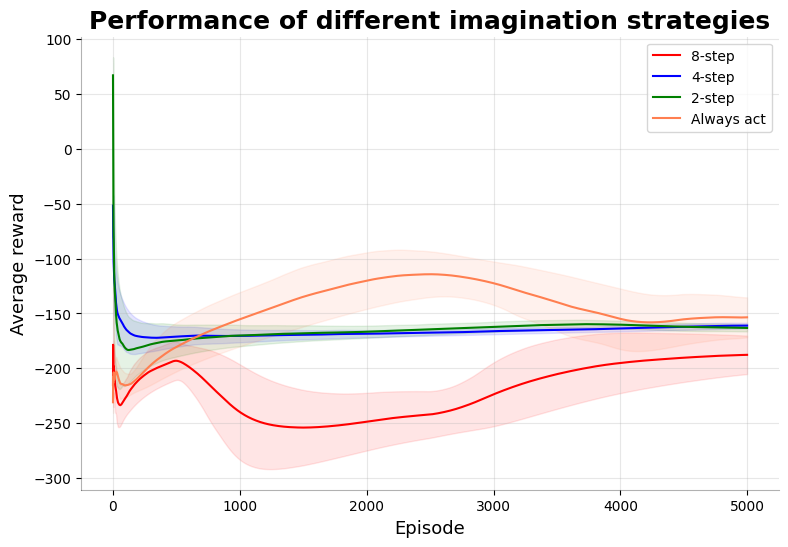

In [ ]:
# Plot avg reward
import matplotlib.colors as mcolors

with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunarlander_plot_2mila_5mila/LunarLander-v2_plot_info_8_step_budget.pickle', 'rb') as handle:
  plot_info_8_step = pickle.load(handle)

with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunarlander_plot_2mila_5mila/LunarLander-v2_plot_info_4_step_budget.pickle', 'rb') as handle:
  plot_info_4_step = pickle.load(handle)

with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunarlander_plot_2mila_5mila/LunarLander-v2_plot_info_2_step_budget.pickle', 'rb') as handle:
  plot_info_2_step = pickle.load(handle)

with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunarlander_plot_2mila_5mila/LunarLander-v2_plot_info_0_step_budget.pickle', 'rb') as handle:
  plot_info_0_step = pickle.load(handle)

episodes = range(plot_info_8_step["n_episodes"])
r_8 = pd.Series(plot_info_8_step["Mean_reward_per_episode"])
r_4 = pd.Series(plot_info_4_step["Mean_reward_per_episode"])
r_2 = pd.Series(plot_info_2_step["Mean_reward_per_episode"])
r_0 = pd.Series(plot_info_0_step["Mean_reward_per_episode"])

r_8_ewm = r_8.ewm(com = 1000).mean()
r_4_ewm = r_4.ewm(com = 1000).mean()
r_2_ewm = r_2.ewm(com = 1000).mean()
r_0_ewm = r_0.ewm(com = 1000).mean()

ci_8 = r_8.ewm(com = 1000).std()
ci_4 = r_4.ewm(com = 1000).std()
ci_2 = r_2.ewm(com = 1000).std()
ci_0 = r_0.ewm(com = 1000).std()

fig = plt.figure(figsize=(9,6), dpi=100)	#identifies the figure 
plt.title("Performance of different imagination strategies", fontsize='18', fontweight="bold")	#title
plt.plot(episodes, r_8_ewm, color=mcolors.CSS4_COLORS["red"])
plt.fill_between(episodes, (r_8_ewm-ci_8), (r_8_ewm+ci_8), color='red', alpha=0.1)
plt.plot(r_4_ewm, color=mcolors.CSS4_COLORS["blue"])
plt.fill_between(episodes, (r_4_ewm-ci_4), (r_4_ewm+ci_4), color='blue',alpha=0.1)
plt.plot(r_2_ewm, color=mcolors.CSS4_COLORS["green"])
plt.fill_between(episodes, (r_2_ewm-ci_2), (r_2_ewm+ci_2), color='green', alpha=0.1)
plt.plot(r_0_ewm, color=mcolors.CSS4_COLORS["coral"])
plt.fill_between(episodes, (r_0_ewm-ci_0), (r_0_ewm+ci_0), color='coral', alpha=0.1)
plt.xlabel("Episode",fontsize='13')	#adds a label in the x axis
plt.ylabel("Average reward",fontsize='13')	#adds a label in the y axis
plt.legend(("8-step", '4-step', "2-step", "Always act"), loc='best')	#creates a legend to identify the plot
#plt.savefig('8_step_vs_4_step.png')	#saves the figure in the present directory
plt.grid(axis='both', alpha=.3)

plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()

## CartPole 2 mile 5mila


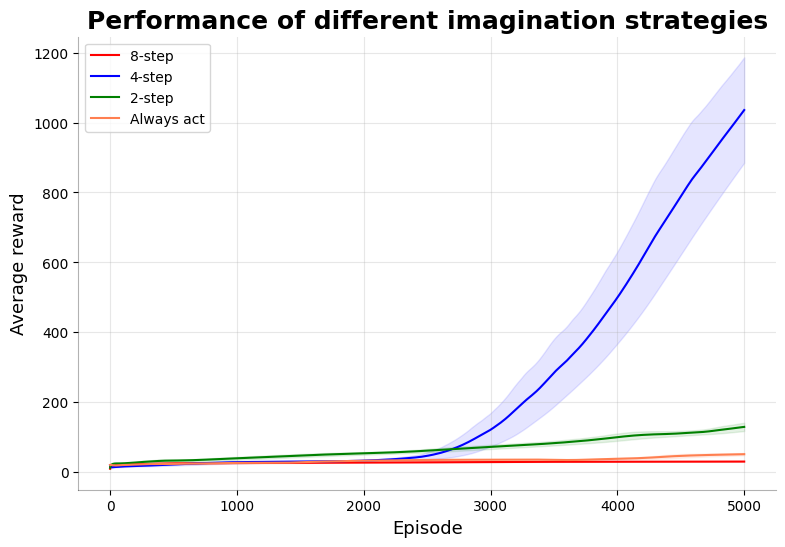

In [ ]:
# Plot avg reward
import matplotlib.colors as mcolors

with open('/content/drive/MyDrive/rl_final_proj/saved_models/cartpole_plot_2mila_5mila/plot_info_8_step_budget.pickle', 'rb') as handle:
  plot_info_8_step = pickle.load(handle)

with open('/content/drive/MyDrive/rl_final_proj/saved_models/cartpole_plot_2mila_5mila/plot_info_4_step_budget.pickle', 'rb') as handle:
  plot_info_4_step = pickle.load(handle)

with open('/content/drive/MyDrive/rl_final_proj/saved_models/cartpole_plot_2mila_5mila/plot_info_2_step_budget.pickle', 'rb') as handle:
  plot_info_2_step = pickle.load(handle)

with open('/content/drive/MyDrive/rl_final_proj/saved_models/cartpole_plot_2mila_5mila/plot_info_0_step_budget.pickle', 'rb') as handle:
  plot_info_0_step = pickle.load(handle)
  episodes = range(plot_info_8_step["n_episodes"])
r_8 = pd.Series(plot_info_8_step["Mean_reward_per_episode"])
r_4 = pd.Series(plot_info_4_step["Mean_reward_per_episode"])
r_2 = pd.Series(plot_info_2_step["Mean_reward_per_episode"])
r_0 = pd.Series(plot_info_0_step["Mean_reward_per_episode"])

r_8_ewm = r_8.ewm(com = 300).mean()
r_4_ewm = r_4.ewm(com = 300).mean()
r_2_ewm = r_2.ewm(com = 300).mean()
r_0_ewm = r_0.ewm(com = 300).mean()

ci_8 = r_8.ewm(com = 300).std()
ci_4 = r_4.ewm(com = 300).std()
ci_2 = r_2.ewm(com = 300).std()
ci_0 = r_0.ewm(com = 300).std()

fig = plt.figure(figsize=(9,6), dpi=100)	#identifies the figure 
plt.title("Performance of different imagination strategies", fontsize='18', fontweight="bold")	#title
plt.plot(episodes, r_8_ewm, color=mcolors.CSS4_COLORS["red"])
plt.fill_between(episodes, (r_8_ewm-ci_8), (r_8_ewm+ci_8), color='red', alpha=0.1)
plt.plot(r_4_ewm, color=mcolors.CSS4_COLORS["blue"])
plt.fill_between(episodes, (r_4_ewm-ci_4), (r_4_ewm+ci_4), color='blue',alpha=0.1)
plt.plot(r_2_ewm, color=mcolors.CSS4_COLORS["green"])
plt.fill_between(episodes, (r_2_ewm-ci_2), (r_2_ewm+ci_2), color='green', alpha=0.1)
plt.plot(r_0_ewm, color=mcolors.CSS4_COLORS["coral"])
plt.fill_between(episodes, (r_0_ewm-ci_0), (r_0_ewm+ci_0), color='coral', alpha=0.1)
plt.xlabel("Episode",fontsize='13')	#adds a label in the x axis
plt.ylabel("Average reward",fontsize='13')	#adds a label in the y axis
plt.legend(("8-step", '4-step', "2-step", "Always act"), loc='best')	#creates a legend to identify the plot
#plt.savefig('8_step_vs_4_step.png')	#saves the figure in the present directory
plt.grid(axis='both', alpha=.3)

plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()

## Lunar 50 mila

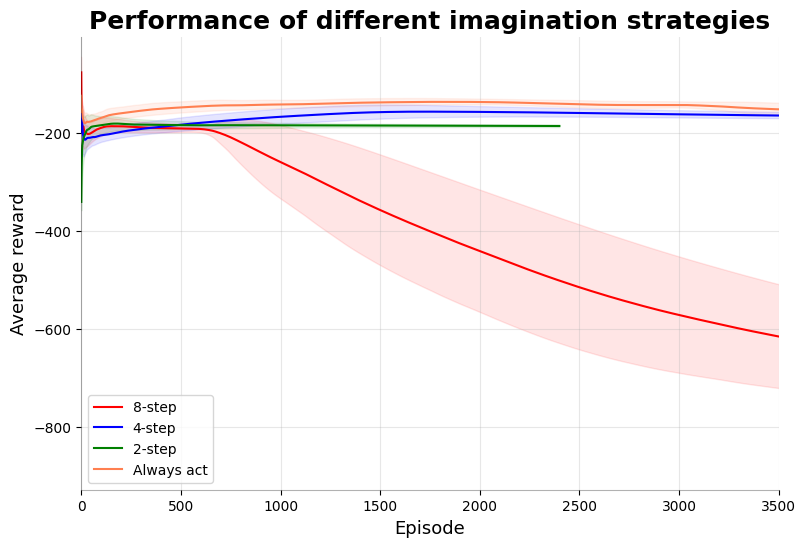

In [ ]:
import matplotlib.colors as mcolors
with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunarlander_plot_5mila_50mila/LunarLander-v2_plot_info_8_step_budget_5000_50000.pickle', 'rb') as handle:
  plot_info_8_step = pickle.load(handle)

with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunarlander_plot_5mila_50mila/LunarLander-v2_plot_info_4_step_budget_5000_50000.pickle', 'rb') as handle:
  plot_info_4_step = pickle.load(handle)
with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunarlander_plot_5mila_50mila/Lunarlander-plot_info_2_step_budget_50mila.pickle', 'rb') as handle:
  plot_info_2_step = pickle.load(handle)
with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunarlander_plot_5mila_50mila/lunarlander_plot_info_0_step_budget_50mila.pickle','rb') as handle:
    plot_info_0_step = pickle.load(handle)



episodes = range(plot_info_8_step["n_episodes"])
r_8 = pd.Series(plot_info_8_step["Mean_reward_per_episode"])
r_4 = pd.Series(plot_info_4_step["Mean_reward_per_episode"])
r_2 = pd.Series(plot_info_2_step["Mean_reward_per_episode"])
r_0 = pd.Series(plot_info_0_step["Mean_reward_per_episode"])

r_8_ewm = r_8.ewm(com = 1000).mean()
r_4_ewm = r_4.ewm(com = 1000).mean()
r_2_ewm = r_2.ewm(com = 1000).mean()
r_0_ewm = r_0.ewm(com = 1000).mean()

ci_8 = r_8.ewm(com = 1000).std()
ci_4 = r_4.ewm(com = 1000).std()
ci_2 = r_2.ewm(com = 1000).std()
ci_0 = r_0.ewm(com = 1000).std()

fig = plt.figure(figsize=(9,6), dpi=100)	#identifies the figure 
plt.title("Performance of different imagination strategies", fontsize='18', fontweight="bold")	#title
plt.plot(range(28800), r_8_ewm, color=mcolors.CSS4_COLORS["red"])
plt.fill_between(range(28800), (r_8_ewm-ci_8), (r_8_ewm+ci_8), color='red', alpha=0.1)
plt.plot(r_4_ewm, color=mcolors.CSS4_COLORS["blue"])
plt.fill_between(range(50000), (r_4_ewm-ci_4), (r_4_ewm+ci_4), color='blue',alpha=0.1)
plt.plot(r_2_ewm, color=mcolors.CSS4_COLORS["green"])
plt.fill_between(range(2400), (r_2_ewm-ci_2), (r_2_ewm+ci_2), color='green', alpha=0.1)
plt.plot(r_0_ewm, color=mcolors.CSS4_COLORS["coral"])
plt.fill_between(range(4200), (r_0_ewm-ci_0), (r_0_ewm+ci_0), color='coral', alpha=0.1)

plt.xlim(0,3500)
plt.xlabel("Episode",fontsize='13')	#adds a label in the x axis
plt.ylabel("Average reward",fontsize='13')	#adds a label in the y axis
plt.legend(("8-step", '4-step', "2-step", "Always act"), loc='best')	#creates a legend to identify the plot
#plt.savefig('8_step_vs_4_step.png')	#saves the figure in the present directory
plt.grid(axis='both', alpha=.3)

plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()

## 50 mila cartpole

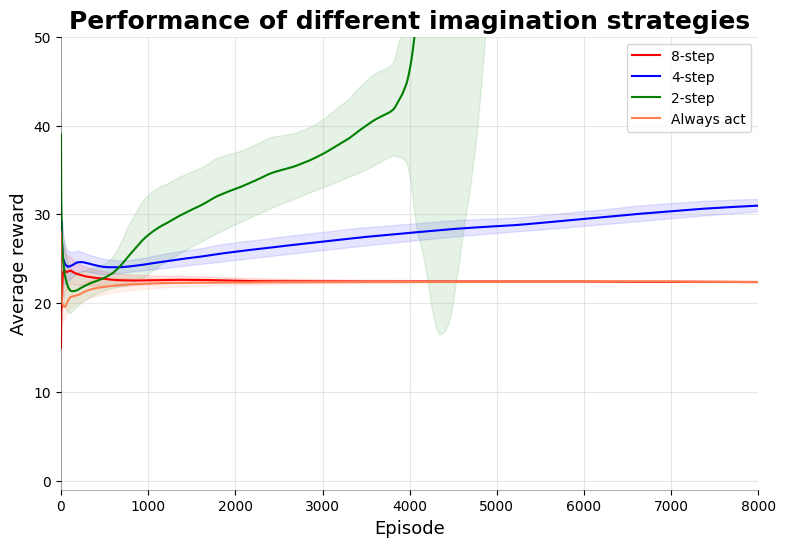

In [ ]:
import matplotlib.colors as mcolors
with open('/content/drive/MyDrive/rl_final_proj/saved_models/cartpole_plot_5mila_50_mila/CartPole-v1_plot_info_8_step_budget_5000_50000.pickle', 'rb') as handle:
  plot_info_8_step = pickle.load(handle)

with open('/content/drive/MyDrive/rl_final_proj/saved_models/cartpole_plot_5mila_50_mila/CartPole-v1_plot_info_4_step_budget_5000_50000.pickle', 'rb') as handle:
  plot_info_4_step = pickle.load(handle)
with open('/content/drive/MyDrive/rl_final_proj/saved_models/cartpole_plot_5mila_50_mila/cartpole-plot_info_2_step_budget_50mila.pickle', 'rb') as handle:
  plot_info_2_step = pickle.load(handle)
with open('/content/drive/MyDrive/rl_final_proj/saved_models/cartpole_plot_5mila_50_mila/cartpole_plot_info_0_step_budget_50mila.pickle','rb') as handle:
    plot_info_0_step = pickle.load(handle)



episodes = range(plot_info_8_step["n_episodes"])
r_8 = pd.Series(plot_info_8_step["Mean_reward_per_episode"])
r_4 = pd.Series(plot_info_4_step["Mean_reward_per_episode"])
r_2 = pd.Series(plot_info_2_step["Mean_reward_per_episode"])
r_0 = pd.Series(plot_info_0_step["Mean_reward_per_episode"])

r_8_ewm = r_8.ewm(com = 1000).mean()
r_4_ewm = r_4.ewm(com = 1000).mean()
r_2_ewm = r_2.ewm(com = 1000).mean()
r_0_ewm = r_0.ewm(com = 1000).mean()

ci_8 = r_8.ewm(com = 1000).std()
ci_4 = r_4.ewm(com = 1000).std()
ci_2 = r_2.ewm(com = 1000).std()
ci_0 = r_0.ewm(com = 1000).std()

fig = plt.figure(figsize=(9,6), dpi=100)	#identifies the figure 
plt.title("Performance of different imagination strategies", fontsize='18', fontweight="bold")	#title
plt.plot(range(50000), r_8_ewm, color=mcolors.CSS4_COLORS["red"])
plt.fill_between(range(50000), (r_8_ewm-ci_8), (r_8_ewm+ci_8), color='red', alpha=0.1)
plt.plot(r_4_ewm, color=mcolors.CSS4_COLORS["blue"])
plt.fill_between(range(26600), (r_4_ewm-ci_4), (r_4_ewm+ci_4), color='blue',alpha=0.1)
plt.plot(r_2_ewm, color=mcolors.CSS4_COLORS["green"])
plt.fill_between(range(7600), (r_2_ewm-ci_2), (r_2_ewm+ci_2), color='green', alpha=0.1)
plt.plot(r_0_ewm, color=mcolors.CSS4_COLORS["coral"])
plt.fill_between(range(50000), (r_0_ewm-ci_0), (r_0_ewm+ci_0), color='coral', alpha=0.1)
plt.ylim(-1,50)
plt.xlim(-1,8000)
plt.xlabel("Episode",fontsize='13')	#adds a label in the x axis
plt.ylabel("Average reward",fontsize='13')	#adds a label in the y axis
plt.legend(("8-step", '4-step', "2-step", "Always act"), loc='best')	#creates a legend to identify the plot
#plt.savefig('8_step_vs_4_step.png')	#saves the figure in the present directory
plt.grid(axis='both', alpha=.3)

plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()

## Easy Lunar

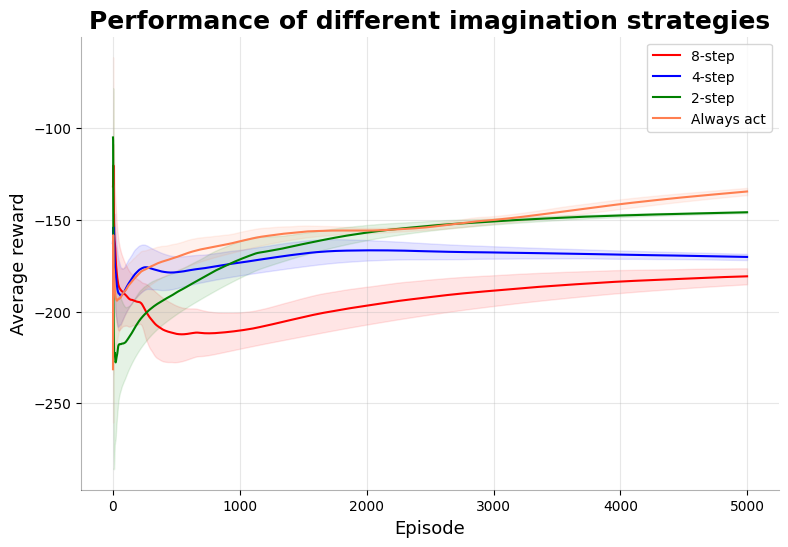

In [ ]:
with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunar_easy/plot_info_8_step_budget(1).pickle', 'rb') as handle:
  plot_info_8_step = pickle.load(handle)
with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunar_easy/plot_info_4_step_budget.pickle', 'rb') as handle:
  plot_info_4_step = pickle.load(handle)
with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunar_easy/plot_info_2_step_budget.pickle', 'rb') as handle:
  plot_info_2_step = pickle.load(handle)
with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunar_easy/plot_info_0_step_budget.pickle', 'rb') as handle:
  plot_info_0_step = pickle.load(handle)



episodes = range(plot_info_8_step["n_episodes"])
r_8 = pd.Series(plot_info_8_step["Mean_reward_per_episode"])
r_4 = pd.Series(plot_info_4_step["Mean_reward_per_episode"])
r_2 = pd.Series(plot_info_2_step["Mean_reward_per_episode"])
r_0 = pd.Series(plot_info_0_step["Mean_reward_per_episode"])

r_8_ewm = r_8.ewm(com = 1000).mean()
r_4_ewm = r_4.ewm(com = 1000).mean()
r_2_ewm = r_2.ewm(com = 300).mean()
r_0_ewm = r_0.ewm(com = 300).mean()

ci_8 = r_8.ewm(com = 1000).std()
ci_4 = r_4.ewm(com = 1000).std()
ci_2 = r_2.ewm(com = 300).std()
ci_0 = r_0.ewm(com = 300).std()

fig = plt.figure(figsize=(9,6), dpi=100)	#identifies the figure 
plt.title("Performance of different imagination strategies", fontsize='18', fontweight="bold")	#title
plt.plot(episodes, r_8_ewm, color=mcolors.CSS4_COLORS["red"])
plt.fill_between(episodes, (r_8_ewm-ci_8), (r_8_ewm+ci_8), color='red', alpha=0.1)
plt.plot(r_4_ewm, color=mcolors.CSS4_COLORS["blue"])
plt.fill_between(episodes, (r_4_ewm-ci_4), (r_4_ewm+ci_4), color='blue',alpha=0.1)
plt.plot(r_2_ewm, color=mcolors.CSS4_COLORS["green"])
plt.fill_between(episodes, (r_2_ewm-ci_2), (r_2_ewm+ci_2), color='green', alpha=0.1)
plt.plot(r_0_ewm, color=mcolors.CSS4_COLORS["coral"])
plt.fill_between(episodes, (r_0_ewm-ci_0), (r_0_ewm+ci_0), color='coral', alpha=0.1)

plt.xlabel("Episode",fontsize='13')	#adds a label in the x axis
plt.ylabel("Average reward",fontsize='13')	#adds a label in the y axis
plt.legend(("8-step", '4-step', "2-step", "Always act"), loc='best')	#creates a legend to identify the plot
#plt.savefig('8_step_vs_4_step.png')	#saves the figure in the present directory
plt.grid(axis='both', alpha=.3)

plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.show()


## Zero Forced (4 step)

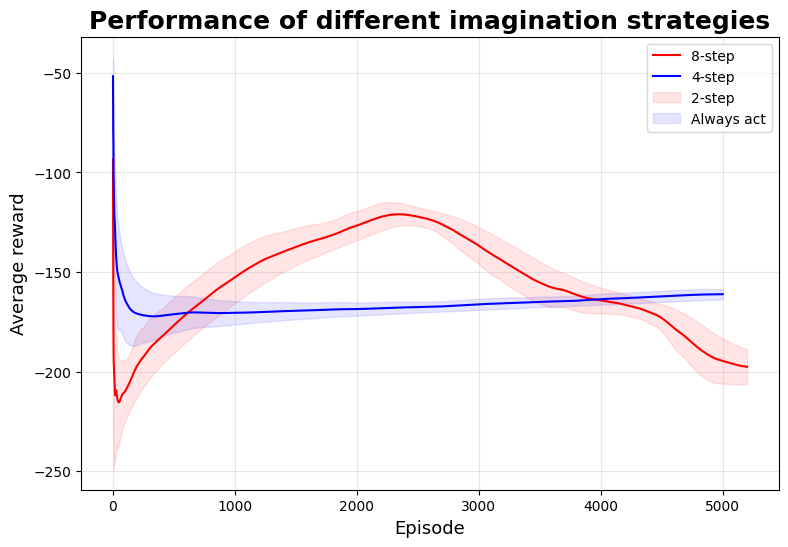

In [ ]:
with open('/content/drive/MyDrive/rl_final_proj/saved_models/ZeroForced/plot_info_0_step_budget(2).pickle', 'rb') as handle:
  plot_info = pickle.load(handle)
with open('/content/drive/MyDrive/rl_final_proj/saved_models/lunarlander_plot_2mila_5mila/LunarLander-v2_plot_info_4_step_budget.pickle', 'rb') as handle:
  plot_info_4_step = pickle.load(handle)



episodes = range(plot_info["n_episodes"])
r = pd.Series(plot_info["Mean_reward_per_episode"])
r_4 = pd.Series(plot_info_4_step["Mean_reward_per_episode"])
r_ewm = r.ewm(com = 300).mean()
r_4_ewm = r_4.ewm(com = 1000).mean()

ci = r.ewm(com = 300).std()
ci_4 = r_4.ewm(com = 1000).std()


fig = plt.figure(figsize=(9,6), dpi=100)	#identifies the figure 
plt.title("Performance of different imagination strategies", fontsize='18', fontweight="bold")	#title
plt.plot(range(5200), r_ewm, color=mcolors.CSS4_COLORS["red"])
plt.fill_between(range(5200), (r_ewm-ci), (r_ewm+ci), color='red', alpha=0.1)
plt.plot(r_4_ewm, color=mcolors.CSS4_COLORS["blue"])
plt.fill_between(range(5000), (r_4_ewm-ci_4), (r_4_ewm+ci_4), color='blue',alpha=0.1)

plt.xlabel("Episode",fontsize='13')	#adds a label in the x axis
plt.ylabel("Average reward",fontsize='13')	#adds a label in the y axis
plt.legend(("8-step", '4-step', "2-step", "Always act"), loc='best')	#creates a legend to identify the plot
#plt.savefig('8_step_vs_4_step.png')	#saves the figure in the present directory
plt.grid(axis='both', alpha=.3)

# Evaluate

In [ ]:
def evaluate(env_id="LunarLander-v2", n_episodes=20, render=False, max_steps_per_episode=500):
  env = gym.make(env_id)
  if render:
      env = gym.make(env_id, render_mode='human')

  # Dimensions
  state_dim = env.observation_space.shape[0]
  action_dim = env.action_space.n
  history_size = state_dim + 1 + 1 + 1
  n_lstm_units = 4

  controller = Controller(state_dim, history_size, action_dim)
  memory =  Memory(history_size, history_size, num_layers=n_lstm_units)
  checkpoint = torch.load("/content/drive/MyDrive/rl_final_proj/saved_models/lunar_lander_2000_episodes/LunarLander-v2_checkpoint")
  controller.load_state_dict(checkpoint["controller"])
  memory.load_state_dict(checkpoint["memory"])

  u = 0 #no imagination

  controller.eval()
      
  rewards = []
  for episode in range(n_episodes):
    total_reward = 0
    done = False
    s, _ = env.reset()
    history = initialize_history(state_dim, 1)

    for i in range(max_steps_per_episode):
      input = torch.cat([torch.tensor(s).flatten(),history]).flatten()
      action, _= controller.act(input)
      
      s, reward, done, truncated, info = env.step(action)
      new_data = torch.cat([torch.tensor(s).flatten(),torch.tensor([action]),torch.tensor([reward]),torch.tensor([u])]).flatten()
      new_data = new_data.unsqueeze(0).type("torch.FloatTensor")
      history = memory(new_data)

      if render: env.render()
      total_reward += reward
      if done or truncated: break
    
    print(total_reward)
    rewards.append(total_reward)
      
  print('Mean Reward:', np.mean(rewards))

In [ ]:
evaluate()

-176.3803945082226
-141.10942353356018
-164.2297517749494
-160.81677918674322
-138.85601844491373
-147.45736714970843
-50.52966426765724
-165.50537216667252
-165.1888936290426
-120.83674891573426
-125.78118043890588
-143.44683971438346
-102.13309772514216
-132.01029503221733
-110.12084283942761
-144.52875153376704
-173.01029495213277
-125.50487336735361
-131.67732513395848
-145.11174001486626
Mean Reward: -138.21178271646795
